In [1]:
import sys

sys.path.append('..')

In [2]:
import os
from av2.datasets.sensor.av2_sensor_dataloader import  AV2SensorDataLoader
from pathlib import Path
import numpy as np

home = os.path.expanduser("~")

# dataset_path = os.path.join(home,"buni","dataset", "av2", "train")
dataset_path = os.path.join(home,"buni","dataset", "av2-pixor", "overfit", "train")
os.listdir(dataset_path)

dataset = AV2SensorDataLoader(Path(dataset_path), Path(dataset_path))
scene_idx = 0
frame_idx = 0
print(dataset.get_log_ids()[scene_idx])
log_id = dataset.get_log_ids()[scene_idx]
print(dataset.get_ordered_log_lidar_timestamps(log_id)[frame_idx])
timestamp = dataset.get_ordered_log_lidar_timestamps(log_id)[frame_idx]

labels = dataset.get_labels_at_lidar_timestamp(log_id, timestamp)
cuboids = labels.vertices_m

ff6adc87-5f47-32f7-b36a-546453c0e332
315968449159644000


In [3]:
from av2.structures.sweep import Sweep
sweep = Sweep.from_feather(dataset.get_lidar_fpath_at_lidar_timestamp(log_id, timestamp))
intesity = sweep.intensity
points = sweep.xyz
points_with_intesity = np.hstack((points, intesity.reshape(-1,1)))

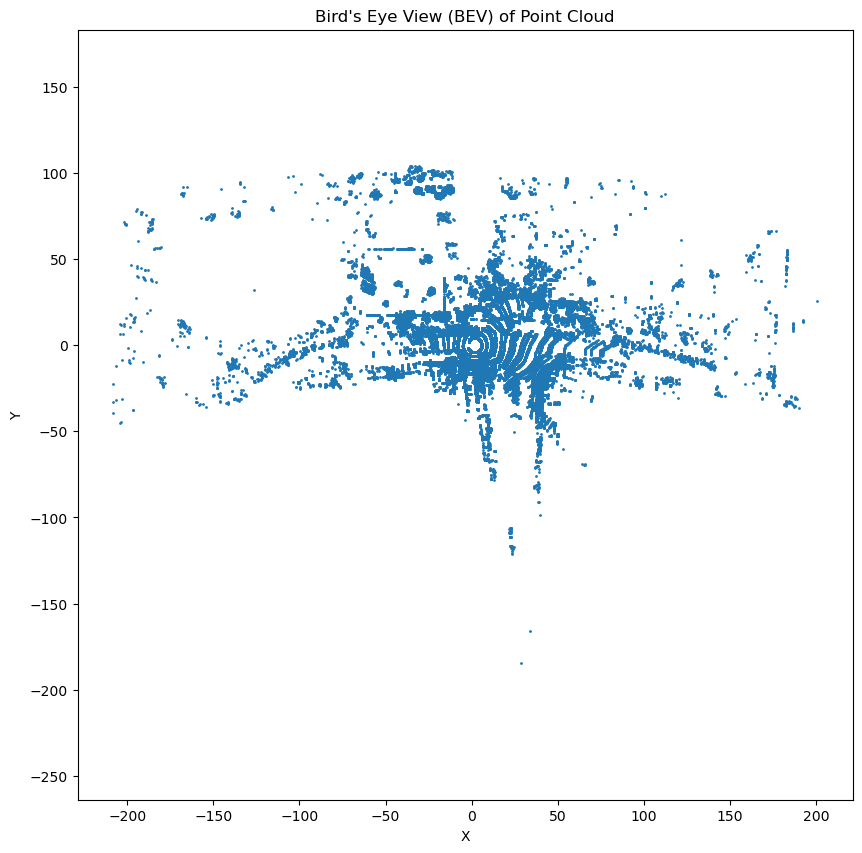

In [4]:
import matplotlib.pyplot as plt

def viz_points2d(points: np.ndarray):
    # Assuming points is an nx3 numpy array
    x = points[:, 0]
    y = points[:, 1]
    plt.figure(figsize=(10, 10))
    plt.scatter(x, y, s=1)  # s is the marker size
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Bird\'s Eye View (BEV) of Point Cloud')
    plt.axis('equal')
    plt.show()
    
viz_points2d(points)

In [5]:
import open3d as o3d

def viz_pd(points):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    # add coordinat axes to the point cloud
    mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10, origin=[0, 0, 0])
    o3d.visualization.draw_geometries([pcd, mesh_frame])

# viz_pd(points)

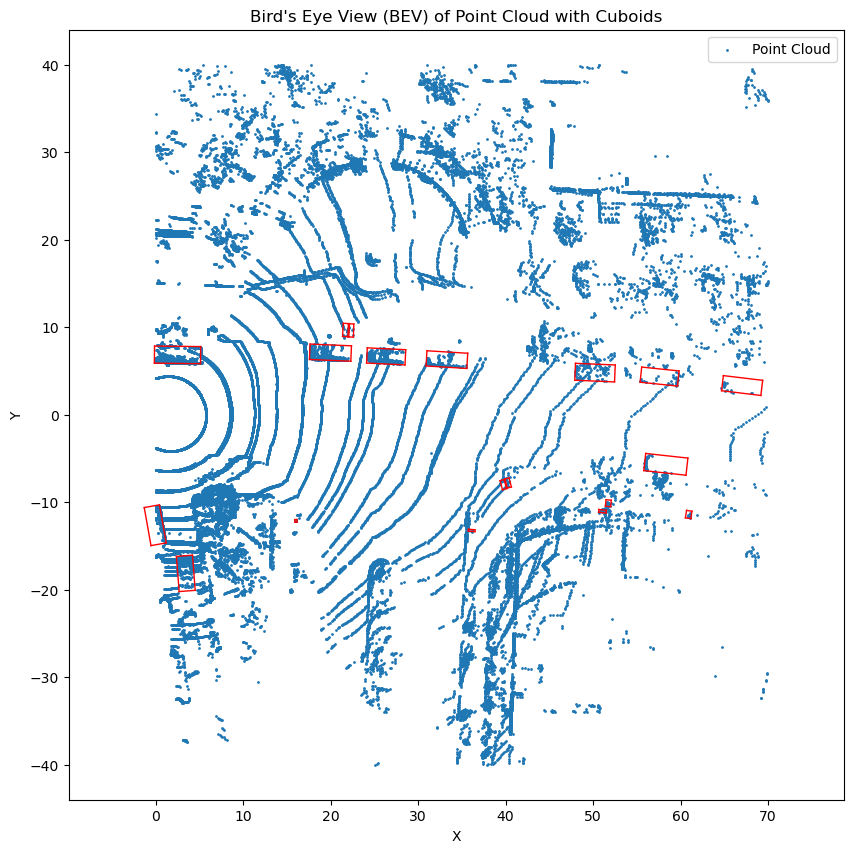

In [6]:
import open3d as o3d
import numpy as np

def visualize_pointcloud_with_cuboids(points, cuboids):
    """
    Visualize a point cloud with cuboids.
    
    Args:
        points (numpy.ndarray): Nx3 array representing the point cloud.
        cuboids (list of numpy.ndarray): Each element is an 8x3 array representing 
                                         the corners of a cuboid.
    """
    # Create Open3D point cloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    
    # Create coordinate frame for reference
    mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10, origin=[0, 0, 0])
    
    # Generate Open3D LineSets for cuboids
    cuboid_geometries = []
    for cuboid in cuboids:
        # Line connections for cuboid wireframe
        lines = [
            [0, 1], [1, 2], [2, 3], [3, 0],  # Bottom face
            [4, 5], [5, 6], [6, 7], [7, 4],  # Top face
            [0, 4], [1, 5], [2, 6], [3, 7]   # Vertical edges
        ]
        
        # Create LineSet for this cuboid
        line_set = o3d.geometry.LineSet()
        line_set.points = o3d.utility.Vector3dVector(cuboid)
        line_set.lines = o3d.utility.Vector2iVector(lines)
        line_set.colors = o3d.utility.Vector3dVector([[1, 0, 0] for _ in lines])  # Red color
        
        cuboid_geometries.append(line_set)
    
    # Visualize point cloud and cuboids
    o3d.visualization.draw_geometries([pcd, mesh_frame] + cuboid_geometries)

# Example usage
# `points` is the Nx3 point cloud array
# `cuboids` is a list of 8x3 arrays representing cuboid corners
# visualize_pointcloud_with_cuboids(points, cuboids)

def extract_face_corners(cuboids: np.ndarray, bottom_face=True):
    """
    Extract corner coordinates of top or bottom face from cuboids.
    
    Args:
        cuboids: numpy array of shape (N, 8, 3) containing cuboid corner coordinates
        bottom_face: bool, if True return bottom face corners, else top face corners
    
    Returns:
        numpy array of shape (N, 4, 2) containing x,y coordinates of face corners
        
              5------4
            |\\    |\\
            | \\   | \\
            6--\\--7  \\
            \\  \\  \\ \\
        l    \\  1-------0    h
         e    \\ ||   \\ ||   e
          n    \\||    \\||   i
           g    \\2------3    g
            t      width.     h
             h.               t
    """
    # Select indices for bottom or top face
    face_index = [0, 1, 5, 4] if bottom_face else [3, 2, 6, 7]
    
    # Extract corners for selected face (x,y coordinates only)
    face_corners = cuboids[:, face_index, :2]
    
    return face_corners

import matplotlib.pyplot as plt
import numpy as np

def visualize_bev_with_cuboids_ROI(points: np.ndarray, cuboids: np.ndarray, fig_size=(10, 10), bottom_face_flag=True):
    """
    Visualize a 2D BEV (Bird's Eye View) of the point cloud with cuboid annotations.

    Args:
        points (numpy.ndarray): Nx3 array representing the point cloud.
        cuboids (numpy.ndarray): Array of shape (N, 8, 3), where N is the number of cuboids,
                                 8 represents the 8 corners, and 3 represents (X, Y, Z) coordinates.
    """
    # Extract the X and Y coordinates from the point cloud
    x = points[:, 0]
    y = points[:, 1]

    # Plot the BEV of the point cloud
    plt.figure(figsize=fig_size)
    plt.scatter(x, y, s=1, label="Point Cloud")  # s=1 for small point size
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title("Bird's Eye View (BEV) of Point Cloud with Cuboids")
    plt.axis('equal')

    cuboids = extract_face_corners(cuboids, bottom_face=bottom_face_flag)
    # Process and visualize each cuboid
    for cuboid in cuboids:
        projected_corners = cuboid
        # Define connections for the cuboid's bottom face (BEV)
        connections = [
            [0, 1], [1, 2], [2, 3], [3, 0]  # Connections between corners of the bottom face
        ]

        # Draw lines for the cuboid in the BEV
        for start, end in connections:
            plt.plot(
                [projected_corners[start, 0], projected_corners[end, 0]],
                [projected_corners[start, 1], projected_corners[end, 1]],
                color='red', linewidth=1
            )
    
    plt.legend()
    plt.show()

def filter_points_and_cuboids(points, corners):
    # Define the ROI range
    x_min, x_max = 0, 70
    y_min, y_max = -40, 40

    # Filter points based on the ROI
    roi_mask = (points[:, 0] >= x_min) & (points[:, 0] <= x_max) & (points[:, 1] >= y_min) & (points[:, 1] <= y_max)
    filtered_points = points[roi_mask]

    # Filter cuboids based on the ROI
    filtered_cuboids = []
    for cuboid in corners:
        if np.any((cuboid[:, 0] >= x_min) & (cuboid[:, 0] <= x_max) & (cuboid[:, 1] >= y_min) & (cuboid[:, 1] <= y_max)):
            filtered_cuboids.append(cuboid)
    filtered_cuboids = np.array(filtered_cuboids)
    return filtered_points, filtered_cuboids


def filter_cuboids_by_roi(corners: np.ndarray, 
                         x_range: tuple = (0, 70), 
                         y_range: tuple = (-40, 40)) -> np.ndarray:
    """
    Filter cuboids based on whether they fall within specified ROI.

    Args:
        corners: numpy array of shape (N, 4, 2) containing corner coordinates
        x_range: tuple of (min_x, max_x) defining ROI x bounds
        y_range: tuple of (min_y, max_y) defining ROI y bounds

    Returns:
        numpy array containing only cuboids that fall within ROI
    """
    x_min, x_max = x_range
    y_min, y_max = y_range

    filtered_cuboids = []
    for cuboid in corners:
        # Check if any corner falls within ROI
        if np.any((cuboid[:, 0] >= x_min) & 
                  (cuboid[:, 0] <= x_max) & 
                  (cuboid[:, 1] >= y_min) & 
                  (cuboid[:, 1] <= y_max)):
            filtered_cuboids.append(cuboid)
    
    return np.array(filtered_cuboids)

# Example usage:
# filtered_cuboids = filter_cuboids_by_roi(corners, x_range=(0,70), y_range=(-40,40))

filtered_points, _ = filter_points_and_cuboids(points, cuboids)
filtered_cuboids = filter_cuboids_by_roi(cuboids)
# Example Usage:
# Assuming `points` is an Nx3 numpy array representing the point cloud
# Assuming `corners` is an (N, 8, 3) numpy array of cuboid corner coordinates
visualize_bev_with_cuboids_ROI(filtered_points, filtered_cuboids, fig_size=(10, 10), bottom_face_flag=True)

In [7]:
import ctypes
import time
import torch
from model import PIXOR
from postprocess import filter_pred, non_max_suppression
from utils import get_bev, plot_bev
class Detector(object):

    def __init__(self, config, cdll: bool):
        self.config = config
        self.cdll = cdll
        if self.cdll:
            self.LidarLib = ctypes.cdll.LoadLibrary('preprocess/LidarPreprocess.so')
        #self.device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
        self.device = torch.device('cpu')
        self.net = PIXOR(config['geometry'], config['use_bn']).to(self.device)

        self.net.set_decode(True)
        self.net.load_state_dict(torch.load(config['ckpt_name'], map_location=self.device))
        self.net.eval()

        for p in self.net.parameters():
            p.require_grad = False

        print("PIXOR BEV Detector Initialized!")

    def preprocess(self, velo: np.ndarray):
        """
        If cdll is True, use C++ library to preprocess all point clouds in the given path argument
        Otherwise, preprocess the point cloud `velo` in python
        
        Args:
            velo: numpy array representing a point cloud
            path: a string containing the path to the binary file of the point cloud
        
        return:
            torch.Tensor of shape (36, 800, 700) 
        """
        geom = self.config['geometry']
        def passthrough(velo):
            q = (geom['W1'] < velo[:, 0]) * (velo[:, 0] < geom['W2']) * \
                (geom['L1'] < velo[:, 1]) * (velo[:, 1] < geom['L2']) * \
                (geom['H1'] < velo[:, 2]) * (velo[:, 2] < geom['H2'])
            indices = np.where(q)[0]
            return velo[indices, :]

        velo = passthrough(velo)
        velo_processed = np.zeros(geom['input_shape'], dtype=np.float32)
        intensity_map_count = np.zeros((velo_processed.shape[0], velo_processed.shape[1]))
        for i in range(velo.shape[0]):
            x = int((velo[i, 1] - geom['L1']) / 0.1)
            y = int((velo[i, 0] - geom['W1']) / 0.1)
            z = int((velo[i, 2] - geom['H1']) / 0.1)
            velo_processed[x, y, z] = 1
            velo_processed[x, y, -1] += velo[i, 3]
            intensity_map_count[x, y] += 1
        velo_processed[:, :, -1] = np.divide(velo_processed[:, :, -1], intensity_map_count, \
                                                where=intensity_map_count != 0)

        velo_processed = torch.from_numpy(velo_processed).permute(2, 0, 1).to(self.device)
        velo_processed.require_grad=False
        return velo_processed

    def postprocess(self, pred):
        cls_pred = pred[..., 0]
        activation = cls_pred > self.config['cls_threshold']
        num_boxes = int(activation.sum())

        if num_boxes == 0:
            print("No bounding box found")
            return [], []

        corners = torch.zeros((num_boxes, 8))
        for i in range(1, 9):
            corners[:, i - 1] = torch.masked_select(pred[i, ...], activation)
        corners = corners.view(-1, 4, 2).numpy()
        scores = torch.masked_select(cls_pred, activation).cpu().numpy()

        # NMS
        selected_ids = non_max_suppression(corners, scores, self.config['nms_iou_threshold'])
        corners = corners[selected_ids]
        scores = scores[selected_ids]

        return corners, scores

    def __call__(self, velo):
        """
        velo is single lidar frame in form of a numpy array
        path is a string containing the path to that binary file of lidar frame
        """
        t_start = time.time()
        bev = self.preprocess(velo)
        t_pre = time.time()
        with torch.no_grad():
            pred = self.net(bev.unsqueeze(0)).squeeze_(0)

        t_m = time.time()
        corners, scores = filter_pred(self.config, pred)
        input_np = bev.permute(1, 2, 0).cpu().numpy()

        t_post = time.time()
        pred_bev = get_bev(input_np, corners)

        t_s = [t_pre-t_start, t_m-t_pre, t_post-t_m]
        return t_s, corners, scores, pred_bev

In [8]:

config = {
      "ckpt_name": "experiments/av2/40epoch_gt",
      "use_bn": True,
      "cls_threshold": 0.5,
      "nms_iou_threshold": 0.1,
      "nms_top": 64,
      "geometry": {
        'L1': -40.0,
        'L2': 40.0,
        'W1': 0.0,
        'W2': 70.0,
        'H1': -2.5,
        'H2': 1.0,
        'grid_size': 0.1,
        'input_shape': [800, 700, 36],
        'label_shape': [200, 175, 7],
        },
    }

In [9]:
def run(points: np.ndarray):
    pixor = Detector(config, cdll=False)
    time, corners, scores, pred_bev = pixor(points)
    return time, corners, scores, pred_bev

_, corners,_, pred_bev = run(points_with_intesity)

C:\Users\Ravi\AppData\Local\Temp\ipykernel_3396\3227258346.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(config['ckpt_name'], map_

FileNotFoundError: [Errno 2] No such file or directory: 'experiments/av2/40epoch_gt'

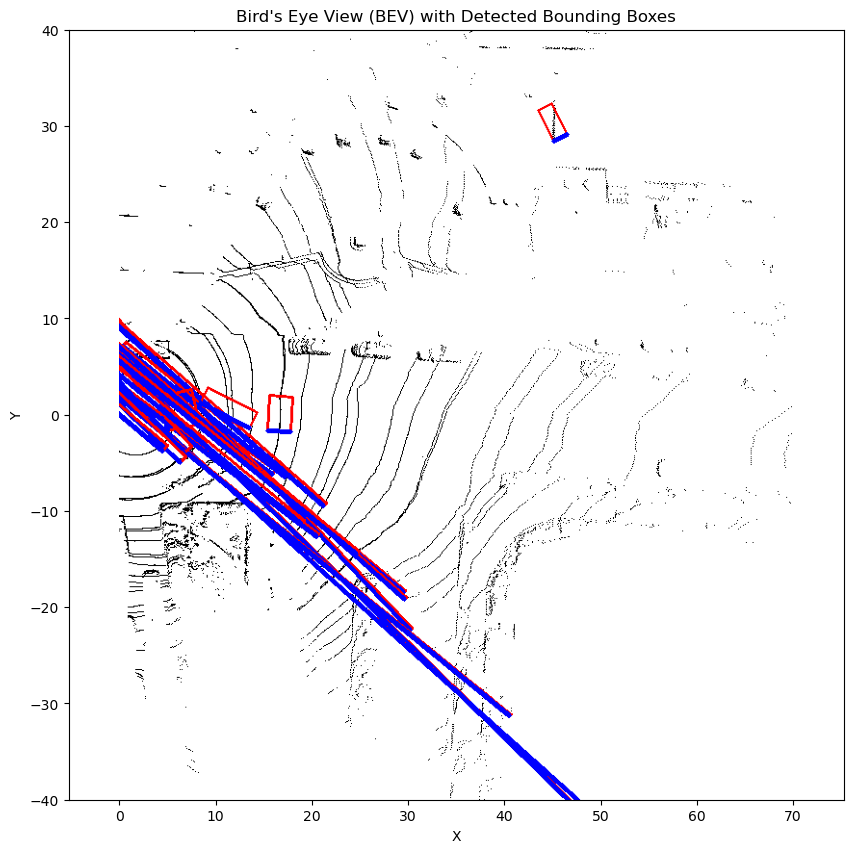

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def plot_pred_bev(pred_bev: np.ndarray):
    """
    Function to plot the Bird's Eye View (BEV) image with detected bounding boxes.
    
    Args:
    - pred_bev: numpy array representing the BEV image with detected bounding boxes overlaid.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(pred_bev, extent=[0, 70, -40, 40])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Bird\'s Eye View (BEV) with Detected Bounding Boxes')
    plt.axis('equal')
    plt.show()

# Example usage
plot_pred_bev(pred_bev)